Load the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\Surface\Masterarbeit')

%matplotlib inline

#path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn6.xlsx"
path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn6.xlsx"

df = pd.read_excel(path)


Transformation Pipeline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import prep
import importlib
importlib.reload(prep)

# set the target variable
target = 'C1_V01_delta_kan'
#print(df.columns)
# get the numerical features
data_num = df.drop(['C1_V01_delta_kan'], axis = 1, inplace=False)
#print(data_num.columns)
# get the target values
data_labels = df[target].to_numpy()

# split the data into training, validation and test sets
# 60% training, 20%, validation, 20% test
X_temp, X_test_prep, y_temp, y_test = train_test_split(data_num, data_labels, test_size= 0.2, random_state=42)
X_train_prep, X_val_prep, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)

# use coustom function "cat_transform" from prep.py to map the categorical features with their frequencies
X_train_prep, X_val_prep, X_test_prep = prep.cat_transform(X_train_prep, X_val_prep, X_test_prep, ['BT_NR', 'STP_NR'])
print(X_train_prep.columns)

# pipeline for preprocessing the data
# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
# get the feature names after preprocessing for the feature importance
feature_names = X_train_prep.columns

# fit the pipeline to the data and transform it
X_train = data_pipeline.fit_transform(X_train_prep)
X_val = data_pipeline.transform(X_val_prep)
X_test = data_pipeline.transform(X_test_prep)

# print the shapes of the data
print(data_num.shape, X_train.shape, X_val.shape, X_test.shape)

Index(['T2', 'K1', 'T20', 'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10',
       'LS_10', 'PP_10', 'TT_10', 'TM5_10', 'RF_10', 'TD_10', 'is_weekend',
       'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin',
       'hour_cos', 'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos',
       'week_sin', 'week_cos', 'Diff_Gegenhalterkraft_HL_1',
       'Diff_Gegenhalterkraft_HR_1', 'Diff_Gegenhalterkraft_VL_1',
       'Diff_Gegenhalterkraft_VR_1', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellung', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
(52011, 39) (31206, 39) (10402, 39) (10403, 39)


Training NN with MC Dropout for Uncertainty quantification

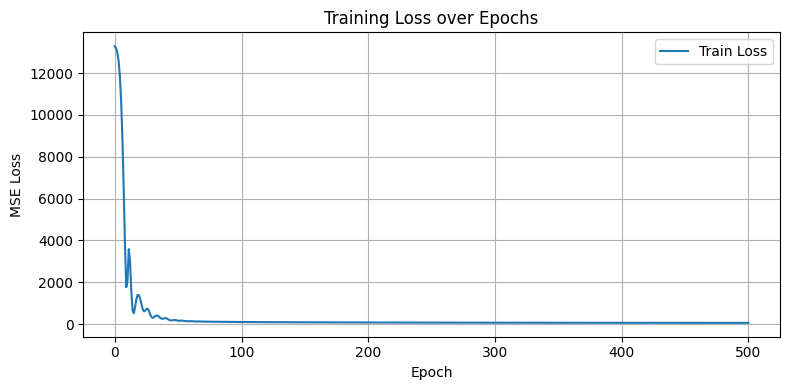

[13284.22265625, 13179.212890625, 12977.037109375, 12567.869140625, 11828.119140625, 10627.681640625, 8848.18359375, 6481.513671875, 3801.3916015625, 1761.02001953125, 2077.238525390625, 3579.0771484375, 3017.51416015625, 1574.975830078125, 640.4703979492188, 514.715576171875, 826.501953125, 1183.9832763671875, 1392.7833251953125, 1384.221923828125, 1207.04541015625, 949.3228149414062, 712.8287963867188, 605.6565551757812, 635.4172973632812, 714.7239379882812, 726.1990356445312, 615.9932250976562, 448.12689208984375, 328.5857238769531, 294.8227844238281, 328.20257568359375, 382.2762756347656, 409.166015625, 389.942138671875, 343.0355529785156, 288.390625, 254.859130859375, 251.4373779296875, 272.5770263671875, 282.2085266113281, 265.00958251953125, 225.435546875, 187.71429443359375, 171.6507110595703, 174.32034301757812, 185.30819702148438, 187.54348754882812, 184.203857421875, 169.26023864746094, 157.57138061523438, 156.9303436279297, 158.88104248046875, 164.2157745361328, 157.8921356

In [3]:
import torch
from IPython.display import clear_output
import numpy as np
from sklearn.metrics import r2_score

# Convert training and testing data to PyTorch tensors
X_tr = torch.from_numpy(X_train).float()
X_te = torch.from_numpy(X_test).float()
y_tr = torch.from_numpy(y_train).float().unsqueeze(1)  # Add extra dimension for compatibility
y_te = torch.from_numpy(y_test).float().unsqueeze(1)


# Define a fully connected neural network with ReLU activations and Dropout
dp = 0.05  # Dropout probability set to 5%
model = torch.nn.Sequential(
    torch.nn.Linear(39, 64),     # Input layer -> 64 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
    torch.nn.Linear(64, 128),   # Hidden layer -> 128 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
    torch.nn.Linear(128, 64),   # Hidden layer -> 64 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
    torch.nn.Linear(64, 1)      # Output layer -> 1 value (regression)
)

# Define Mean Squared Error loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Set learning rate and optimizer
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr)

# Track loss history during training
loss_history = []

# Set model to training mode
model.train()
for i in range(1000):
    optimizer.zero_grad()               # Reset gradients
    y_pred = model(X_tr)                # Forward pass
    loss = loss_fn(y_pred, y_tr)        # Compute MSE loss
    loss.backward()                     # Backpropagation
    optimizer.step()                    # Update weights
    loss_history.append(loss.item())    # Save loss value

    # Update plot every 50 epochs
    if i % 500 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        plt.plot(loss_history, label='Train Loss', color='tab:blue')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Training Loss over Epochs')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
print(loss_history)

Plot the uncertainty interval for the NN with MC Dropout

R² on Train Data: 0.732
R² on Test Data: 0.719
Coverage: 99.00%


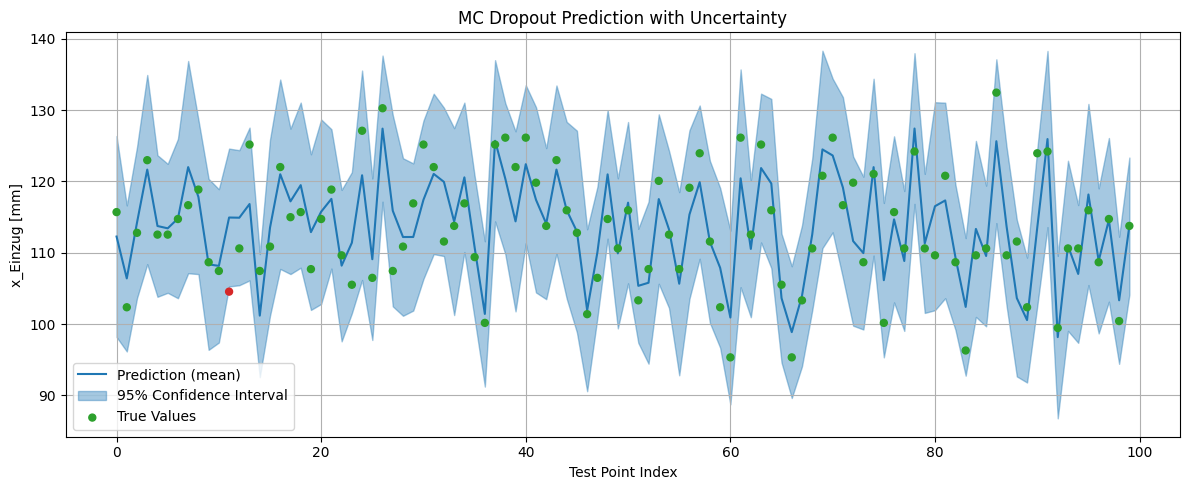

In [5]:
# Keep the model in training mode to keep dropout active
model.train()
# Number of stochastic forward passes for MC Dropout
n_samples = 50

#! handling the train data
# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred = torch.stack([model(X_tr) for i in range(n_samples)]).detach().numpy() #list comprehension for the number of stochastic forward passes for MC Dropout
# Calculate the mean and standard deviation of the predictions on the train data
y_train_pred_mean = y_train_pred.mean(axis = 0)
y_train_Pred_std = y_train_pred.std(axis = 0)

# Calculate R² score on the train data
r2_train = r2_score(y_train, y_train_pred_mean)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred = torch.stack([model(X_te) for i in range(n_samples)]).detach().numpy()
# Calculate the mean and standard deviation of the predictions on the test data
y_test_pred_mean = y_test_pred.mean(axis = 0)
y_test_pred_std = y_test_pred.std(axis = 0)

# Calculate R² score for the test data
r2_test = r2_score(y_te, y_test_pred_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = y_test_pred_mean.flatten()  # Predicted mean for each test point
mc_std = y_test_pred_std.flatten()    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = mc_mean[random_indices] - 2 * mc_std[random_indices]
mc_upper_bound = mc_mean[random_indices] + 2 * mc_std[random_indices]

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test[random_indices] >= mc_lower_bound) & (y_test[random_indices] <= mc_upper_bound)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound, mc_upper_bound, alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_te[random_indices].flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()